# Libraries

In [1]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
from importlib import reload
import plot_utils
import textflappy_env
import seaborn as sns
import matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.distributions import Categorical
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [3]:
sns.set_style('whitegrid')
sns.set_palette('bright')

In [45]:
reload(sys.modules['plot_utils'])

<module 'plot_utils' from 'e:\\My Drive\\Dsba\\05 M2 T2\\Reinforcement Learning\\Individual assignment\\plot_utils.py'>

In [5]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': [16,5]})

In [6]:
def plot_rewards(all_reward_sums, show_last=200, args={}):
    mean_rewards = np.mean(all_reward_sums, axis=0)[-show_last:]
    std_rewards = sem(all_reward_sums, axis=0)[-show_last:]
    x_data =np.arange(len(all_reward_sums[0]) - show_last,len(all_reward_sums[0]))
    sns.lineplot(x=x_data, y=mean_rewards, label=args.get('label','Rewards'))
    plt.fill_between(x_data, mean_rewards + std_rewards, mean_rewards- std_rewards, alpha=0.2)
    plt.xlabel("Episodes")
    plt.ylabel("Sum of reward during episode",rotation=90, labelpad=10)
    # plt.xlim(len(mean_rewards) - show_last,len(mean_rewards))
    # plt.ylim(0,500)
    plt.legend()
    plt.show()

In [7]:
episode_durations=[]

In [8]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations[-1000:], dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    lns1 = plt.plot(durations_t.numpy(), label='Duration')
    plt.legend(loc=0)     

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Setup

In [9]:
height = 15
width = 20
pipe_gap = 4
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
env_screen = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = pipe_gap)
obs = env.reset()

In [10]:
states = env.observation_space[0].n * env.observation_space[1].n
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0, 'trace_decay':0.8}

In [11]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)


The state is made up of 2-tuple of:
* The distance in x of the player from the center of the closest pipe.
* The distance in y of the player from the center of the closest pipe.

The actions are:
* 0: Idle
* 1: Flap

In [12]:
for i_episode in range(3):
    state = env.reset()
    total = 0
    while True:
        action = env.action_space.sample()
        state, reward, done, truncated, info = env.step(action)
        print((state, reward, done, truncated, info))
        total+=reward
        if done:
            print('End game! Reward: ', total)
            break

((12, -1), 1, False, False, {'score': 0, 'player': [6, 6], 'distance': 12.041594578792296})
((11, 0), 1, False, False, {'score': 0, 'player': [6, 7], 'distance': 11.0})
((10, 3), 1, False, False, {'score': 0, 'player': [6, 10], 'distance': 10.44030650891055})
((9, 8), 1, True, False, {'score': 0, 'player': [6, 15], 'distance': 12.041594578792296})
End game! Reward:  4
((12, 2), 1, False, False, {'score': 0, 'player': [6, 6], 'distance': 12.165525060596439})
((11, 1), 1, False, False, {'score': 0, 'player': [6, 5], 'distance': 11.045361017187261})
((10, 2), 1, False, False, {'score': 0, 'player': [6, 6], 'distance': 10.198039027185569})
((9, 5), 1, False, False, {'score': 0, 'player': [6, 9], 'distance': 10.295630140987})
((8, 10), 1, False, False, {'score': 0, 'player': [6, 14], 'distance': 12.806248474865697})
((7, 11), 1, True, False, {'score': 0, 'player': [6, 15], 'distance': 13.038404810405298})
End game! Reward:  6
((12, 3), 1, False, False, {'score': 0, 'player': [6, 6], 'distan

# Agents

## $\lambda Sarsa$

In [13]:
class LambdaSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            agent_init_info (dict): The parameters used to initialize the agent. The dictionary contains:
                {
                    num_states (int): The number of states,
                    num_actions (int): The number of actions,
                    epsilon (float): The epsilon parameter for exploration,
                    step_size (float): The step-size,
                    discount (float): The discount factor,
                    trace_decay (float): The trace decay parameter (lambda),
                }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.trace_decay = agent_init_info["trace_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.q = defaultdict(lambda: np.zeros(self.num_actions))  # The action-value estimates.
        self.e = defaultdict(lambda: np.zeros(self.num_actions))  # Eligibility traces.

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        
        Args:
            state (int): The state from the environment's env_start function.
        
        Returns:
            action (int): The first action the agent takes.
        """
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        
        Args:
            reward (float): The reward received for taking the last action.
            state (int): The state from the environment's step based on where the agent ended up after the last step.
        
        Returns:
            action (int): The action the agent is taking.
        """
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        delta = reward + self.discount*self.q[state][action] - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        for s in self.q:
            for a in range(self.num_actions):
                self.q[s][a] += self.step_size * delta * self.e[s][a]
                self.e[s][a] *= self.discount * self.trace_decay
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        
        Args:
            reward (float): The reward the agent received for entering the terminal state.
        """
        delta = reward - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        for s in self.q:
            for a in range(self.num_actions):
                self.q[s][a] += self.step_size * delta * self.e[s][a]
                self.e[s][a] *= self.discount * self.trace_decay

    def argmax(self, q_values):
        """argmax with random tie-breaking.
        
        Args:
            q_values (numpy.array): The array of action-values.
        
        Returns:
            action (int): An action with the highest value.
        """
        top = float("-inf")
        ties = []
        # print(q_values)
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)


## Fixed policy agent

In [14]:
class FixedAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            agent_init_info (dict): The parameters used to initialize the agent. The dictionary contains:
                {
                    num_states (int): The number of states,
                    num_actions (int): The number of actions,
                    epsilon (float): The epsilon parameter for exploration,
                    step_size (float): The step-size,
                    discount (float): The discount factor,
                    trace_decay (float): The trace decay parameter (lambda),
                }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.trace_decay = agent_init_info["trace_decay"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.q = defaultdict(lambda: np.zeros(self.num_actions))  # The action-value estimates.
        self.e = defaultdict(lambda: np.zeros(self.num_actions))  # Eligibility traces.
        if(agent_init_info.get("qvalues", False)):
            for key, value in agent_init_info.get("qvalues").items():
                self.q[key] = value
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        
        Args:
            state (int): The state from the environment's env_start function.
        
        Returns:
            action (int): The first action the agent takes.
        """
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        
        Args:
            reward (float): The reward received for taking the last action.
            state (int): The state from the environment's step based on where the agent ended up after the last step.
        
        Returns:
            action (int): The action the agent is taking.
        """
        current_q = self.q[state]
        # if self.rand_generator.rand() < self.epsilon:
        #     action = self.rand_generator.randint(self.num_actions)
        # else:
        #     action = self.argmax(current_q)
        # No exploration, only fixed
        action = self.argmax(current_q)
        delta = reward + self.discount*self.q[state][action] - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        # for s in self.q:
        #     for a in range(self.num_actions):
        #         self.q[s][a] += self.step_size * delta * self.e[s][a]
        #         self.e[s][a] *= self.discount * self.trace_decay
        
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        
        Args:
            reward (float): The reward the agent received for entering the terminal state.
        """
        delta = reward - self.q[self.prev_state][self.prev_action]
        self.e[self.prev_state][self.prev_action] += 1
        
        # for s in self.q:
        #     for a in range(self.num_actions):
        #         self.q[s][a] += self.step_size * delta * self.e[s][a]
        #         self.e[s][a] *= self.discount * self.trace_decay

    def argmax(self, q_values):
        """argmax with random tie-breaking.
        
        Args:
            q_values (numpy.array): The array of action-values.
        
        Returns:
            action (int): An action with the highest value.
        """
        top = float("-inf")
        ties = []
        # print(q_values)
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)


# Experiments

## Constant $\alpha-MC$

In [15]:
def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon/nA) 
    return policy_s

In [16]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0]
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [17]:
# On-policy first-visit MC control (for "-soft policies),
def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [18]:
episode_durations =[]

In [19]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05, plot_results=False):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    rewards = []
    epsilon = eps_start
    # loop over episodes
    for i_episode in tqdm(range(1, num_episodes+1), leave=False, desc='episode'):
        # monitor progress
        if i_episode % 1000 == 0:
            # print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            # sys.stdout.flush()
            if(plot_results):
                plot_durations()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        rewards.append(sum([r[1] for r in episode]))
        episode_durations.append(sum([r[1] for r in episode]))
        
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards

In [ ]:
episode_durations =[]
num_runs = 5
num_episodes = 20000
all_rewards_mc = []
all_policies= []
all_q= []
for run in tqdm(range(num_runs), leave=False, desc='run'):
    p, q, r = mc_control(env, num_episodes, 0.5,0.3,eps_decay=0.99, plot_results=False)
    all_rewards_mc.append(r)
    all_policies.append(p)
    all_q.append(q)

Save results

In [ ]:
os.makedirs('results', exist_ok=True)
np.save(f'results/mc_rew.npy', all_rewards_mc)
np.save(f'results/mc_policies.npy', all_policies)
np.save(f'results/mc_qvals.npy', np.array([dict(x) for x in all_q]) )

In [ ]:
all_rewards_mc = np.load(f'results/mc_rew.npy')

In [41]:
def getAverage(V_values):
    # Average Dictionary over the last episode
    # Iterate through each in V_values
    summed_values = {}
    for values_dict in V_values:
        # Initialize a dictionary to store the summed values for each state-action pair
        # Iterate through each run's V_values array
        # Iterate through each state-action pair
        for state, action_values in values_dict.items():
            # Sum the values for each state-action pair
            if state not in summed_values:
                summed_values[state] = action_values
            else:
                summed_values[state] += action_values
        # Divide the summed values by the number of runs to get the average
        averaged_values = {state: action_values/ len(V_values)
                        for state, action_values in summed_values.items()}
        
        # Store the averaged values in the averaged_V_values dictionary
        averaged_V_values = averaged_values
    return averaged_V_values

In [ ]:
# Load 500 K rewards
mc_rewards_500 = np.load(f'results/mc_rew_500K.npy')

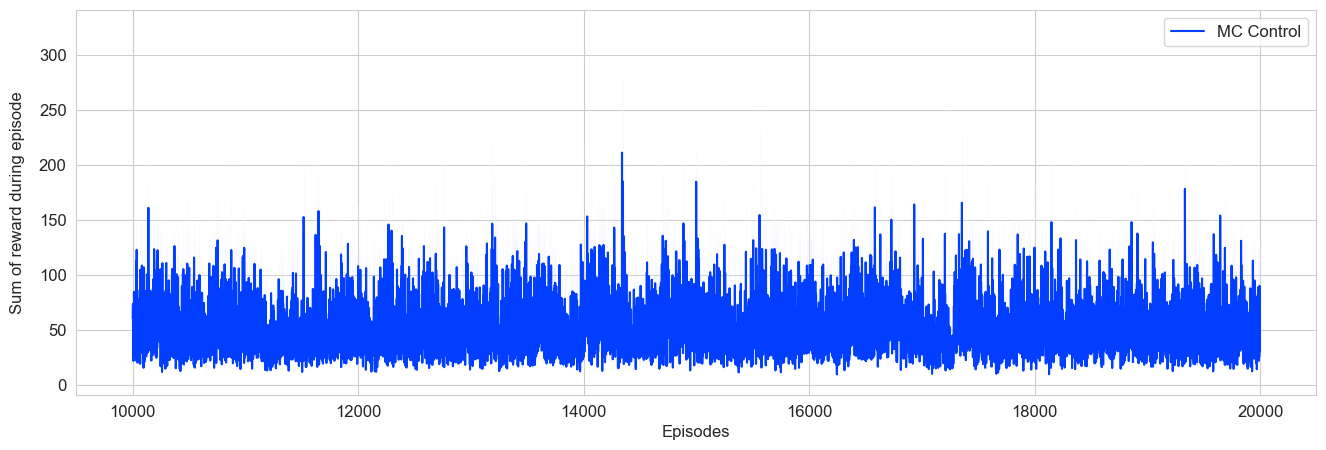

In [ ]:
show_last = 10000
mean_rewards = np.mean(all_rewards_mc, axis=0)[-show_last:]
std_rewards = sem(all_rewards_mc, axis=0)[-show_last:]
sns.lineplot(x=np.arange(len(all_rewards_mc[0]) - show_last,len(all_rewards_mc[0])), y=mean_rewards, label='MC Control')
plt.fill_between(np.arange(len(all_rewards_mc[0]) - show_last,len(all_rewards_mc[0])), mean_rewards + std_rewards, mean_rewards- std_rewards, alpha=0.2)
plt.xlabel("Episodes")
plt.ylabel("Sum of reward during episode",rotation=90, labelpad=10)
# plt.xlim(len(mean_rewards) - show_last,len(mean_rewards))
# plt.ylim(0,500)
plt.legend()
plt.show()

In [ ]:
policy, Q, rewards_mc = mc_control(env, 500000, 0.1, plot_results=False)

100%|██████████| 500000/500000 [36:31<00:00, 228.16it/s]


Save results

In [ ]:
np.save(f'results/mc_qvals_500K.npy', dict(Q))
np.save(f'results/mc_rew_500K.npy', rewards_mc)
np.save(f'results/mc_policy_500K.npy', policy)

In [ ]:
rewards_mc = np.load(f'results/mc_rew_500K.npy')

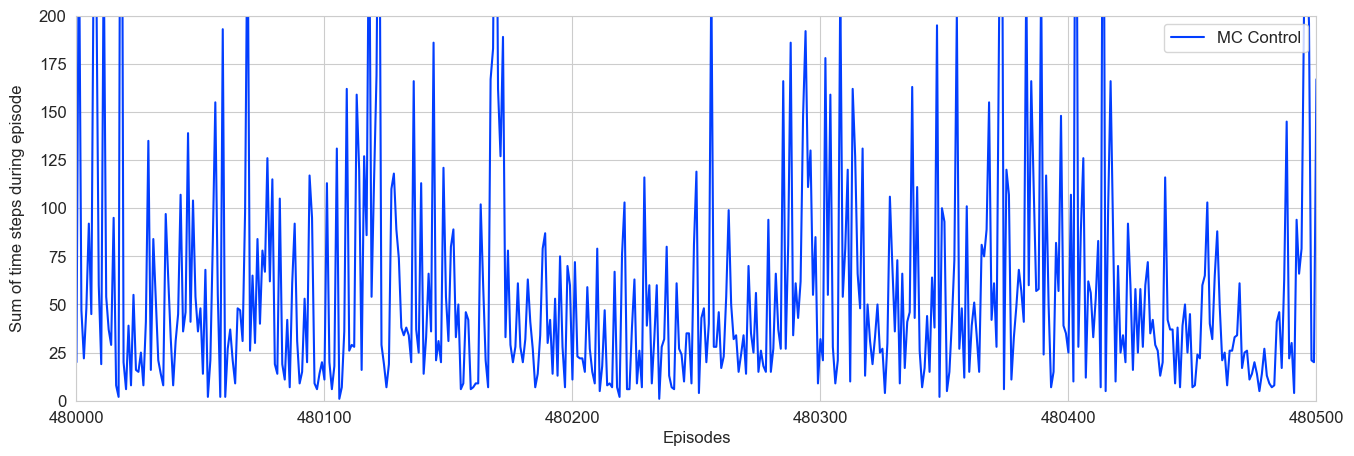

In [ ]:
mean_rewards = rewards_mc
sns.lineplot(x=np.arange(len(mean_rewards)), y=mean_rewards, label='MC Control')
plt.xlabel("Episodes")
plt.ylabel("Sum of time steps during episode",rotation=90, labelpad=10)
plt.xlim(480000,480500)
plt.ylim(0,200)
plt.legend()
plt.show()

In [ ]:
V = dict((k,np.max(v)) for k, v in Q.items())

181.4891973642865


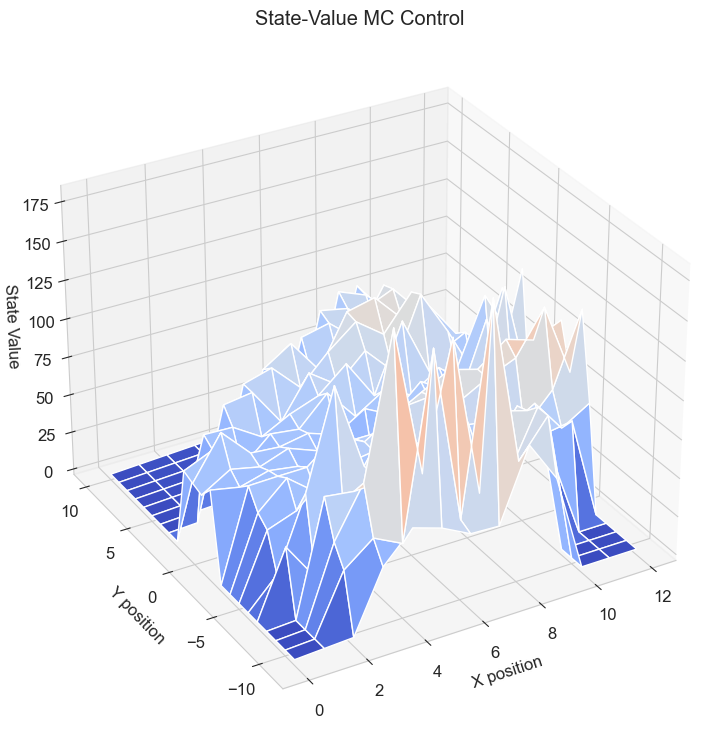

In [ ]:
plot_utils.plot_flappyBird_values(V,height, width, pipe_gap, {'title':'State-Value MC Control'})

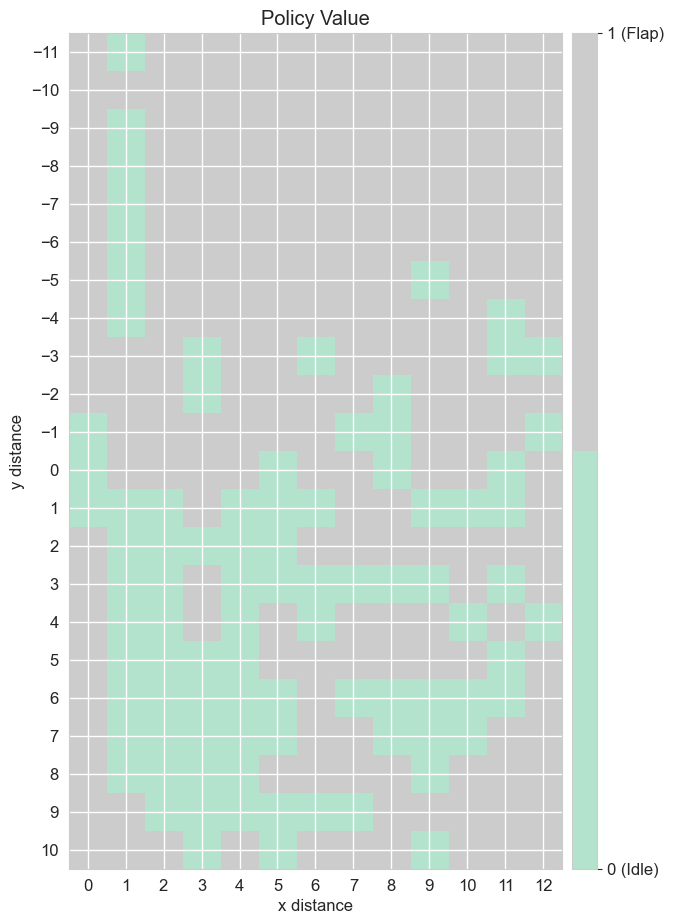

In [ ]:
plot_utils.plot_policy(policy, height, width, pipe_gap)

### Test the learned MC policy

In [ ]:
# Load saved q value function
all_q = np.load(f'results/mc_qvals.npy', allow_pickle=True)
avg_q_MC = getAverage(all_q)

In [ ]:
agents_f = {
    "Fixed Agent": FixedAgent,
}
# algos = ["Lambda Sarsa"]
algos = ["Fixed Agent"]
all_reward_sums = {} # Contains sum of rewards during episode
all_scores_sums = {} # Contains sum of scores during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
V_values = {} # Contains state visit counts during the last 10 episodes

num_runs = 10 # The number of runs
num_episodes = 100 # The number of episodes in each run
max_episode_steps = 1000
env_info_changed = {'height': height, 'width': width, 'pipe_gap':pipe_gap}
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_scores_sums[algorithm] = []
    V_values[algorithm] = []
    for run in tqdm(range(num_runs)):
        # Create environment
        env = gym.make('TextFlappyBird-v0', **env_info_changed)
        # Create Agent
        agent_info["seed"] = run
        # Initialize Q value from learned policy
        agent_info["qvalues"] = avg_q_MC
        current_agent = agents_f[algorithm]()
        current_agent.agent_init(agent_info)
        reward_sums = []
        scores_sums = []
        state_visits = defaultdict(lambda: 0)
        for episode in tqdm(range(num_episodes), desc='Episode', leave=False):
            total_reward = 0
            state = env.reset()[0]
            action = current_agent.agent_start(state)
            # state_visits[state] += 1
            done = False
            t = 0
            while (not done):
                state, reward, done, _, info = env.step(action)
                next_action = current_agent.agent_step(reward, state)
                action = next_action
                if done == True:
                    current_agent.agent_end(reward)
                total_reward += reward
                t += 1
                if(t> max_episode_steps):
                    # print("Reached max episode limit")
                    break
            reward_sums.append(total_reward)
            scores_sums.append(info['score'])
            if episode % 100 == 0 and episode != 0:
                recent_mean_reward = np.mean(reward_sums)
                if recent_mean_reward > 100:
                    # print(f'Run {run}, Episode {episode}, Mean Reward: {recent_mean_reward}')
                    recent_reward_sums = []  # Clear recent rewards after printing
        all_scores_sums[algorithm].append(scores_sums)
        all_reward_sums[algorithm].append(reward_sums)
        env.close()
       

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


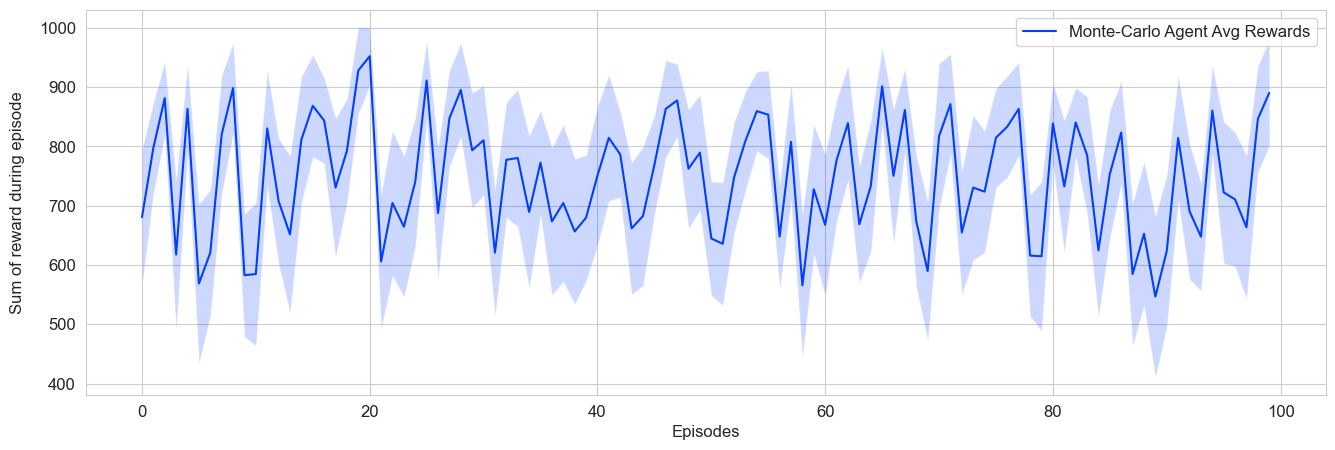

In [ ]:
plot_rewards(all_reward_sums['Fixed Agent'],100, {'label':'Monte-Carlo Agent Avg Rewards'})

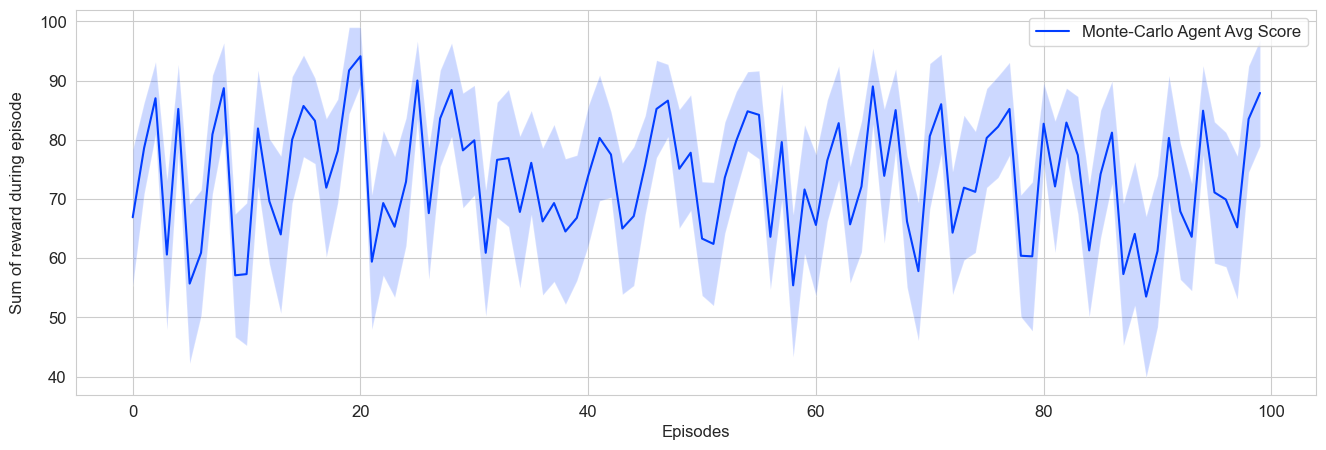

In [ ]:
plot_rewards(all_scores_sums['Fixed Agent'],100, {'label':'Monte-Carlo Agent Avg Score'})

### Impact of parameters

#### Impact of step -size

In [ ]:
reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
num_runs = 10
num_episodes = 1000
all_rewards_mc = []
all_policies = []
all_q= []
for step_size in step_sizes:
    reward_sums[step_size] = []
    for run in tqdm(range(num_runs), leave=False, desc='run'):
        p, q, r = mc_control(env, num_episodes, step_size, plot_results=False)
        all_rewards_mc.append(r)
        all_policies.append(p)
        all_q.append(q)
        reward_sums[step_size].append(np.sum(r)/num_episodes)

run:   0%|          | 0/10 [00:00<?, ?it/s]

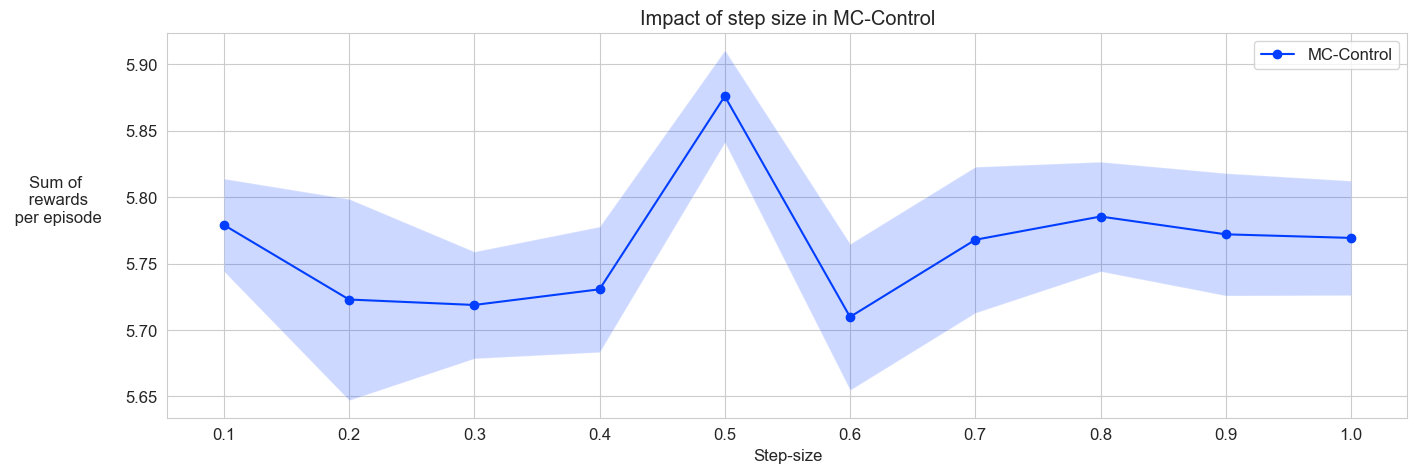

In [ ]:
reward_means = np.array([np.mean(reward_sums[step_size]) for step_size in step_sizes])
reward_stds = np.array([sem(reward_sums[step_size]) for step_size in step_sizes])
plt.plot(step_sizes, reward_means, marker='o', linestyle='solid', label='MC-Control')
plt.fill_between(step_sizes, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.title("Impact of step size in MC-Control")
plt.xticks(step_sizes)
plt.show()

### Impact of discount factor

In [ ]:
reward_sums = {}
discount_factors = np.linspace(0.1,1.0,10)
num_runs = 10
num_episodes = 1000
all_rewards_mc = []
all_policies = []
all_q= []
for df in discount_factors:
    reward_sums[df] = []
    for run in tqdm(range(num_runs), leave=False, desc='run'):
        p, q, r = mc_control(env, num_episodes, 0.5, df, plot_results=False)
        all_rewards_mc.append(r)
        all_policies.append(p)
        all_q.append(q)
        reward_sums[df].append(np.sum(r)/num_episodes)

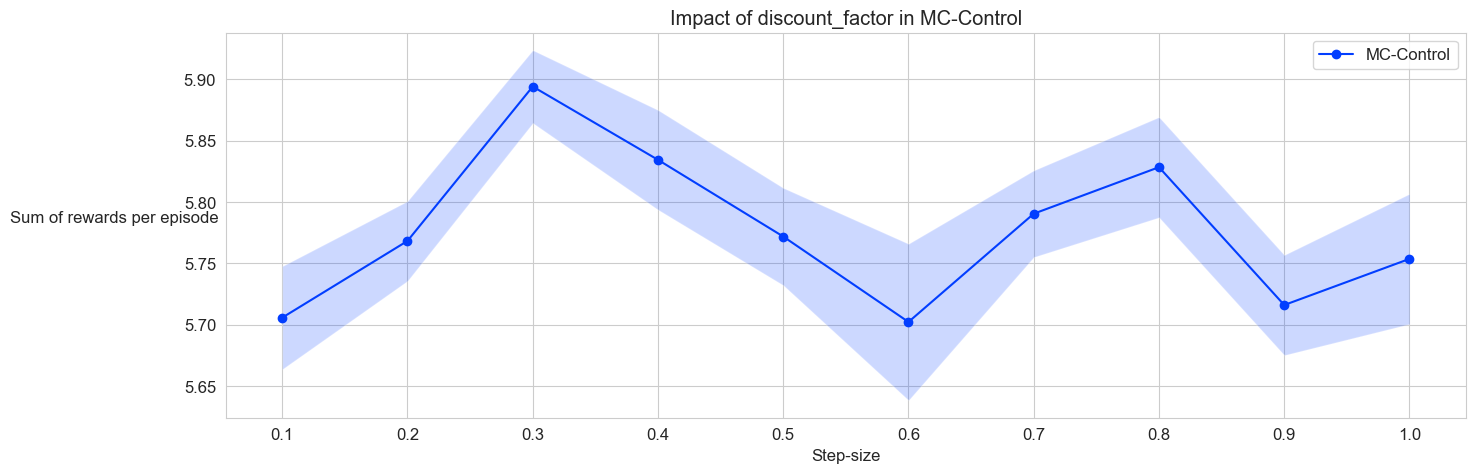

In [ ]:
reward_means = np.array([np.mean(reward_sums[df]) for df in discount_factors])
reward_stds = np.array([sem(reward_sums[df]) for df in discount_factors])
plt.plot(step_sizes, reward_means, marker='o', linestyle='solid', label='MC-Control')
plt.fill_between(step_sizes, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of rewards per episode",rotation=0, labelpad=50)
plt.title("Impact of discount_factor in MC-Control")
plt.xticks(discount_factors)
plt.show()

### Impact of epsilon decay

In [ ]:
reward_sums = {}
eps_decays = np.linspace(0.1,0.99,10)
num_runs = 10
num_episodes = 1000
all_rewards_mc = []
all_policies = []
all_q= []
for eps_decay in tqdm(eps_decays):
    reward_sums[eps_decay] = []
    for run in tqdm(range(num_runs), leave=False, desc='run'):
        p, q, r = mc_control(env, num_episodes, 0.5, 0.3, eps_decay=eps_decay, plot_results=False)
        all_rewards_mc.append(r)
        all_policies.append(p)
        all_q.append(q)
        reward_sums[eps_decay].append(np.sum(r)/num_episodes)

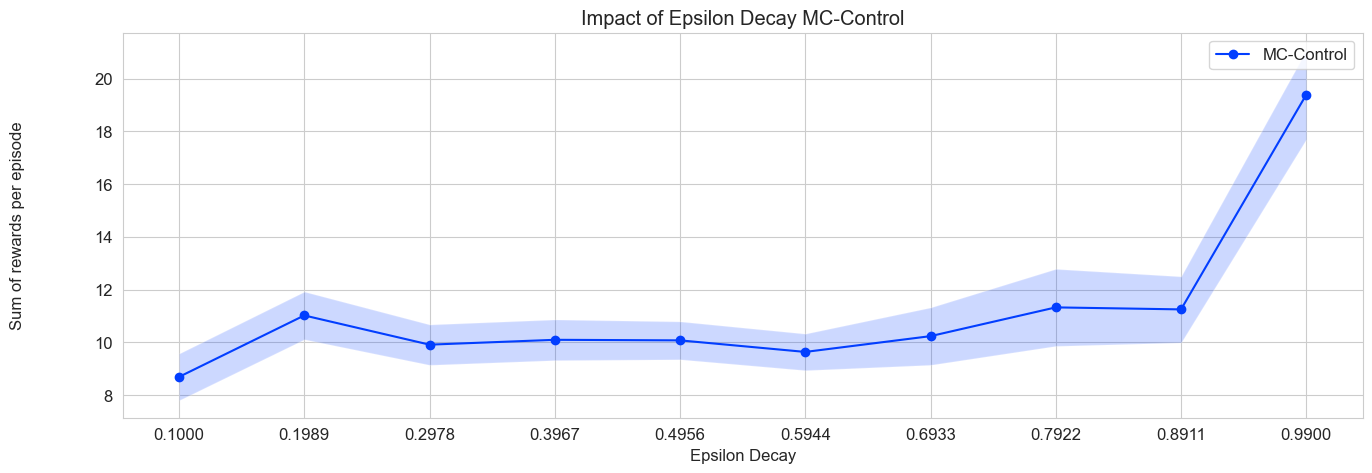

In [ ]:
reward_means = np.array([np.mean(reward_sums[ed]) for ed in eps_decays])
reward_stds = np.array([sem(reward_sums[ed]) for ed in eps_decays])
plt.plot(eps_decays, reward_means, marker='o', linestyle='solid', label='MC-Control')
plt.fill_between(eps_decays, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Epsilon Decay")
plt.ylabel("Sum of rewards per episode",rotation=90, labelpad=50)
plt.title("Impact of Epsilon Decay MC-Control")
plt.xticks(eps_decays)
plt.show()

## Lambda Sarsa

In [22]:
env_info = {'height': height, 'width': width, 'pipe_gap':pipe_gap} # Same environment settings as MC
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "seed": 0, 'trace_decay':0.7}

### Training

In [ ]:
agents = {
    "Lambda Sarsa": LambdaSarsaAgent,
}
# algos = ["Lambda Sarsa"]
algos = ["Lambda Sarsa"]
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores_sums = {} # Contains sum of scores during episode
V_values = {} # Contains state visit counts during the last 10 episodes
num_runs = 10 # The number of runs
num_episodes = 20000 # The number of episodes in each run
max_episode_steps = 1000 # Limit the max episode steps to avoid inifinite loops
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_scores_sums[algorithm] = []
    all_state_visits[algorithm] = []
    V_values[algorithm] = []
    for run in tqdm(range(num_runs)):
        # Create environment
        env = gym.make('TextFlappyBird-v0', **env_info)
        # Create Agent
        agent_info["seed"] = run
        current_agent = agents[algorithm]()
        current_agent.agent_init(agent_info)
        reward_sums = []
        scores_sums = []
        state_visits = defaultdict(lambda: 0)
        for episode in tqdm(range(num_episodes), desc='Episode', leave=False):
            total_reward = 0
            state = env.reset()[0]
            action = current_agent.agent_start(state)
            # state_visits[state] += 1
            done = False
            t = 0
            while (not done):
                state, reward, done, _, info = env.step(action)
                next_action = current_agent.agent_step(reward, state)
                action = next_action
                if done == True:
                    current_agent.agent_end(reward)
                total_reward += reward
                t += 1
                if(t> max_episode_steps):
                    # print("Reached max episode limit")
                    break
            reward_sums.append(total_reward)
            scores_sums.append(info['score'])
            if episode % 100 == 0 and episode != 0:
                recent_mean_reward = np.mean(reward_sums)
                if recent_mean_reward > 100:
                    # print(f'Run {run}, Episode {episode}, Mean Reward: {recent_mean_reward}')
                    recent_reward_sums = []  # Clear recent rewards after printing
     
        all_reward_sums[algorithm].append(reward_sums)
        all_scores_sums[algorithm].append(scores_sums)
        # all_state_visits[algorithm].append(state_visits)
        # Keep track of state values after last episode
        V_values[algorithm].append(current_agent.q)
        env.close()
       

### Plot training

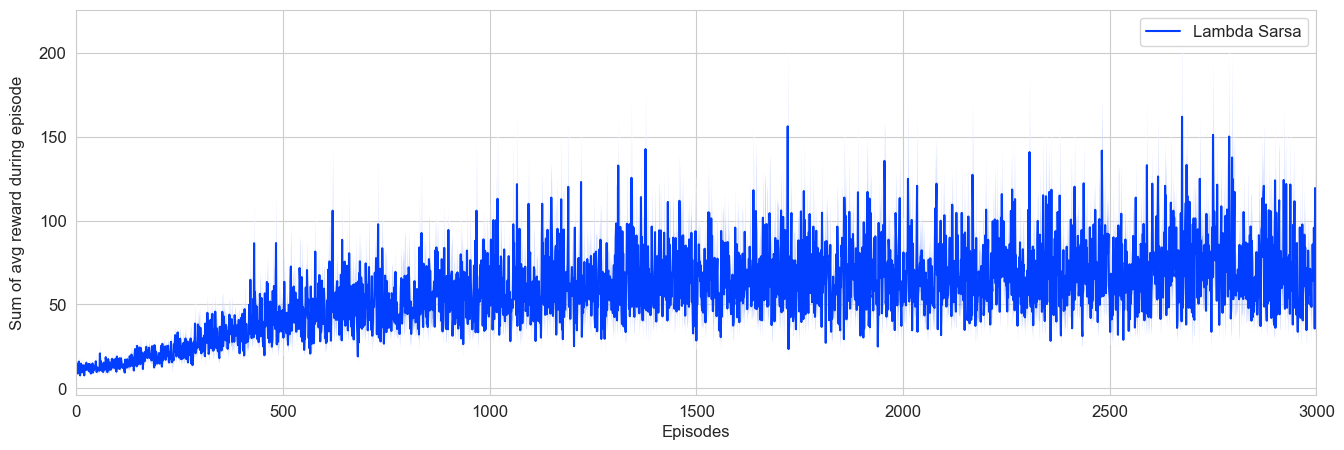

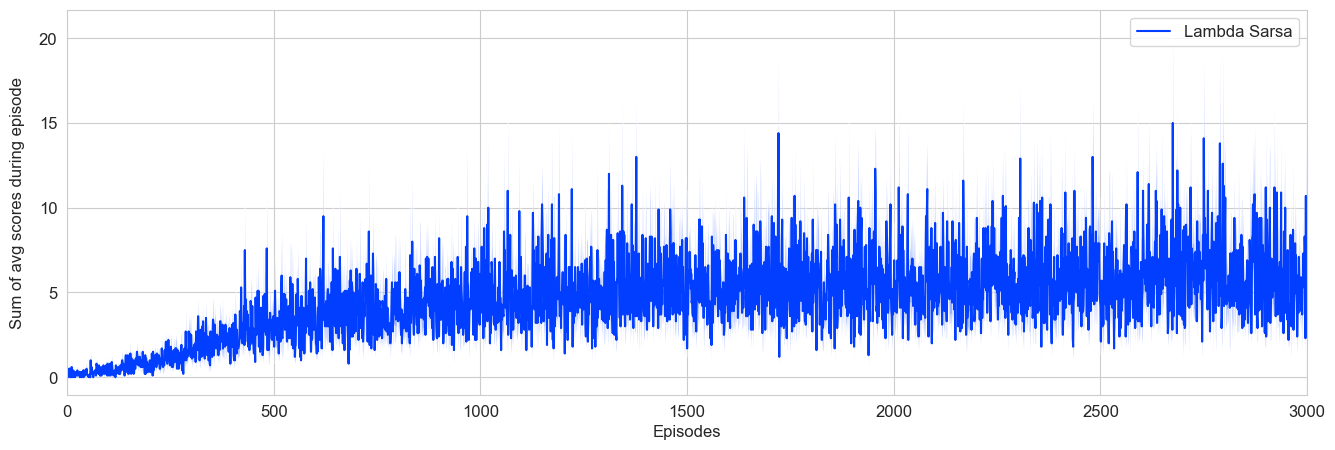

In [44]:
for algorithm in algos:
    # plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
    mean_rewards = np.mean(all_reward_sums[algorithm], axis=0)
    std_rewards = np.std(all_reward_sums[algorithm], axis=0) / np.sqrt(num_runs)
    
    sns.lineplot(x=np.arange(num_episodes), y=mean_rewards, label=algorithm)
    plt.fill_between(np.arange(num_episodes), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.4)
plt.xlabel("Episodes")
plt.ylabel("Sum of avg reward during episode",rotation=90, labelpad=10)
plt.xlim(0,num_episodes)
# plt.ylim(8000,10000)
plt.legend()
plt.show()
for algorithm in algos:
    # plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
    mean_scores = np.mean(all_scores_sums[algorithm], axis=0)
    std_scores = sem(all_scores_sums[algorithm], axis=0)
    sns.lineplot(x=np.arange(num_episodes), y=mean_scores, label=algorithm)
    plt.fill_between(np.arange(num_episodes), mean_scores - std_scores, mean_scores + std_scores, alpha=0.4)
plt.xlabel("Episodes")
plt.ylabel("Sum of avg scores during episode",rotation=90, labelpad=10)
plt.xlim(0,num_episodes)
# plt.ylim(8000,10000)
plt.legend()
plt.show()

Last 200 episodes rewards:

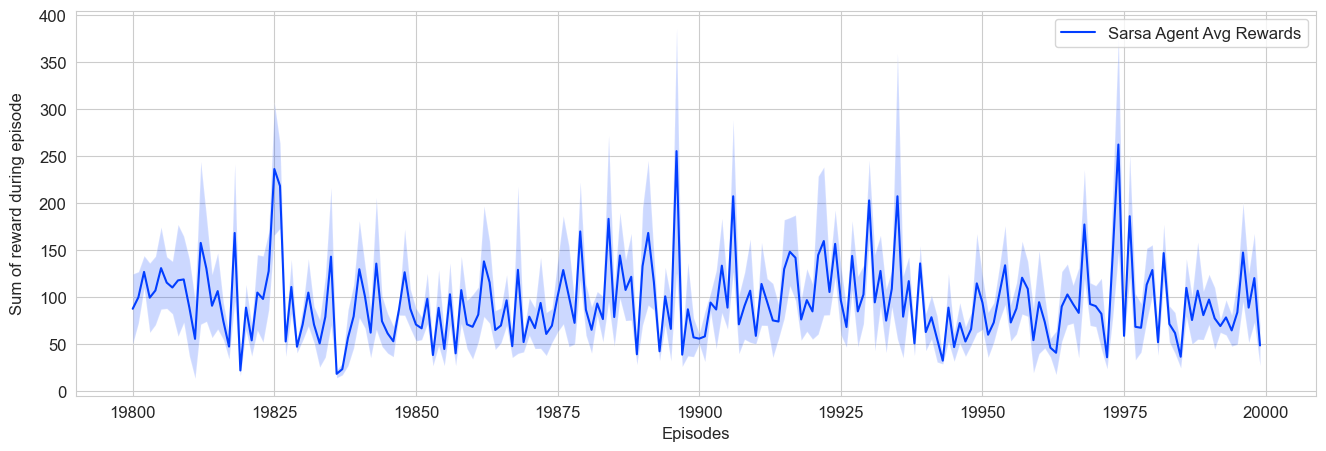

In [96]:
plot_rewards(all_reward_sums['Lambda Sarsa'],200, {'label':'Sarsa Agent Avg Rewards'})

### Save results

Save the data

In [97]:
# save results
import os
import shutil
for algorithm in algos:
    os.makedirs('results', exist_ok=True)
    np.save(f'results/{algorithm}_rew.npy', all_reward_sums[algorithm])
    np.save(f'results/{algorithm}_visits.npy', np.array([dict(x) for x in all_state_visits[algorithm]]))
    np.save(f'results/{algorithm}_qvalues.npy', np.array([dict(x) for x in V_values[algorithm]]))
    
shutil.make_archive('results', 'zip', '.', 'results')

'e:\\My Drive\\Dsba\\05 M2 T2\\Reinforcement Learning\\Individual assignment\\results.zip'

Get the average value function 

In [45]:
# Average Dictionary over the last episode
averaged_V_values = {}
# Iterate through each algorithm in V_values
for algorithm, values_array in V_values.items():
    # Initialize a dictionary to store the summed values for each state-action pair
    summed_values = {}
    # Iterate through each run's V_values array
    for values_dict in values_array: # Per run
        # Iterate through each state-action pair
        for state, action_values in values_dict.items():
            # Sum the values for each state-action pair
            if state not in summed_values:
                summed_values[state] = action_values
            else:
                summed_values[state] += action_values
    # Divide the summed values by the number of runs to get the average
    averaged_values = {state: action_values/ len(values_array)
                       for state, action_values in summed_values.items()}
    
    # Store the averaged values in the averaged_V_values dictionary
    averaged_V_values[algorithm] = averaged_values

In [70]:
np.save(f'results/{algorithm}_avg_V_values.npy', np.array(averaged_V_values[algorithm]))

### Load saved results

In [47]:
# Load saved data
algorithm = 'Lambda Sarsa'
rew_sarsa = np.load(f'results/{algorithm}_rew.npy')
q_values = np.load(f'results/{algorithm}_qvalues_v2.npy', allow_pickle=True)
avg_q_vals = getAverage(q_values)

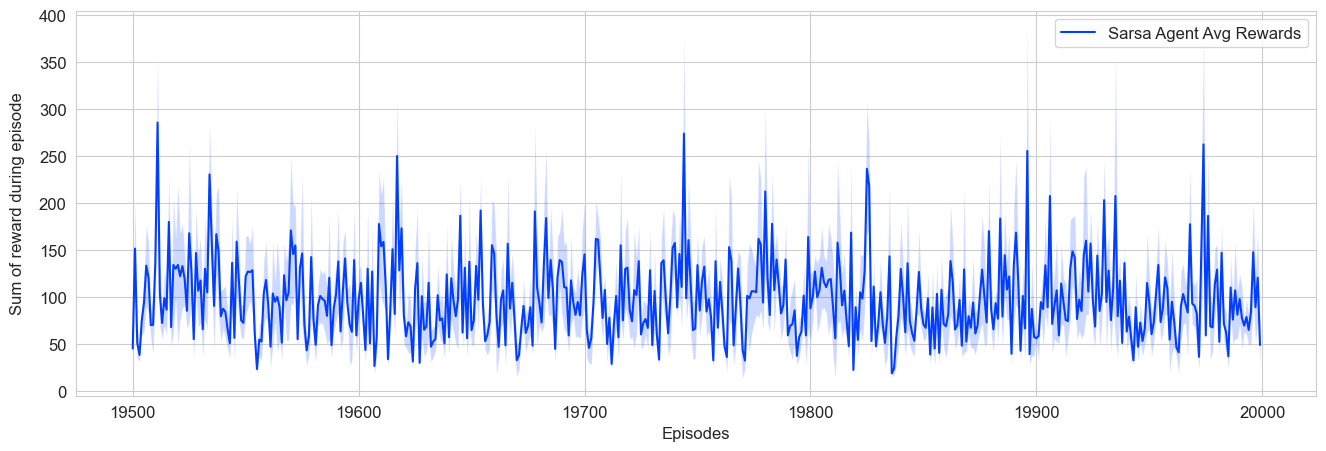

In [68]:
plot_rewards(rew_sarsa, 500, {'label':'Sarsa Agent Avg Rewards'})

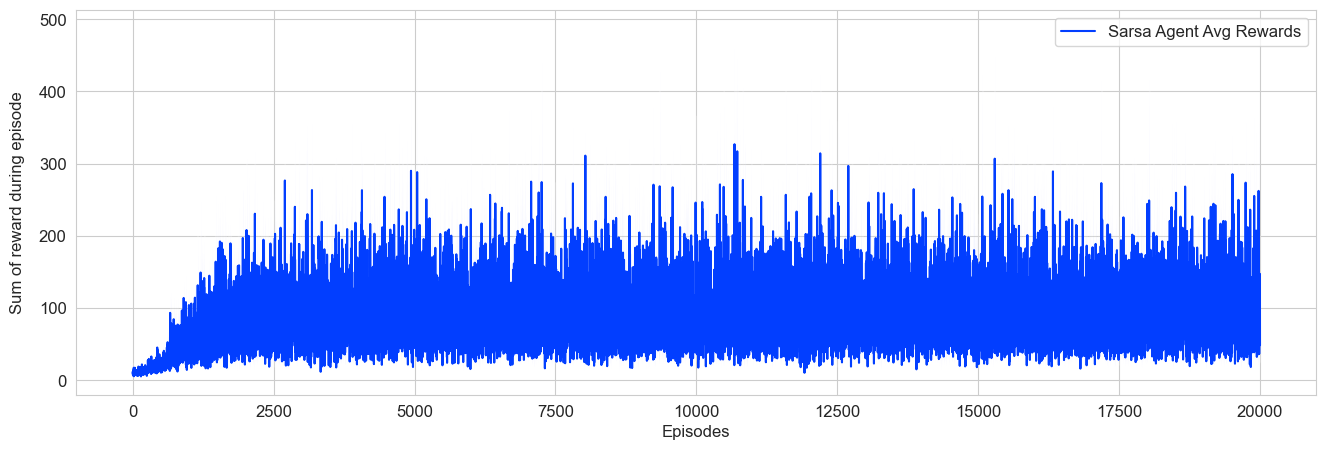

In [66]:
plot_rewards(rew_sarsa, 20000, {'label':'Sarsa Agent Avg Rewards'})

### State-Value

229.39891709890122


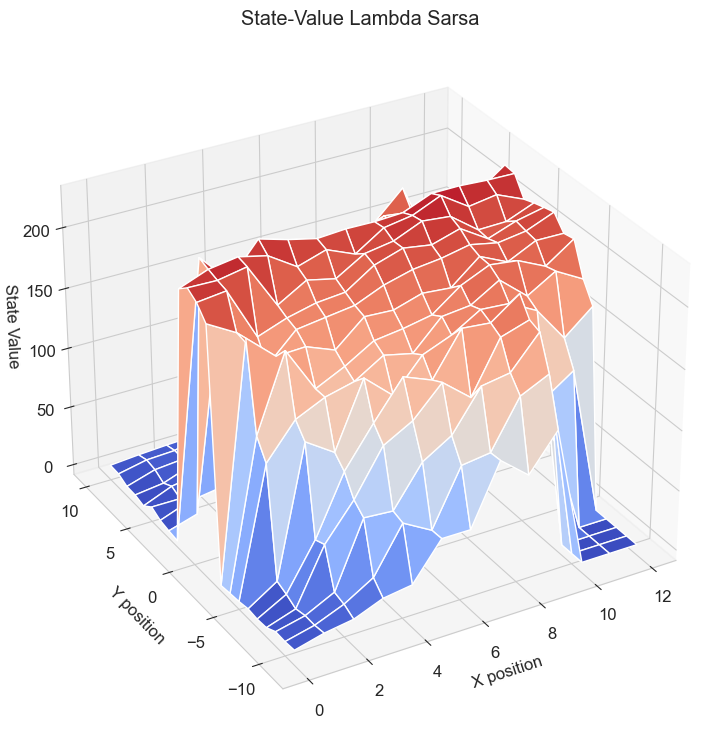

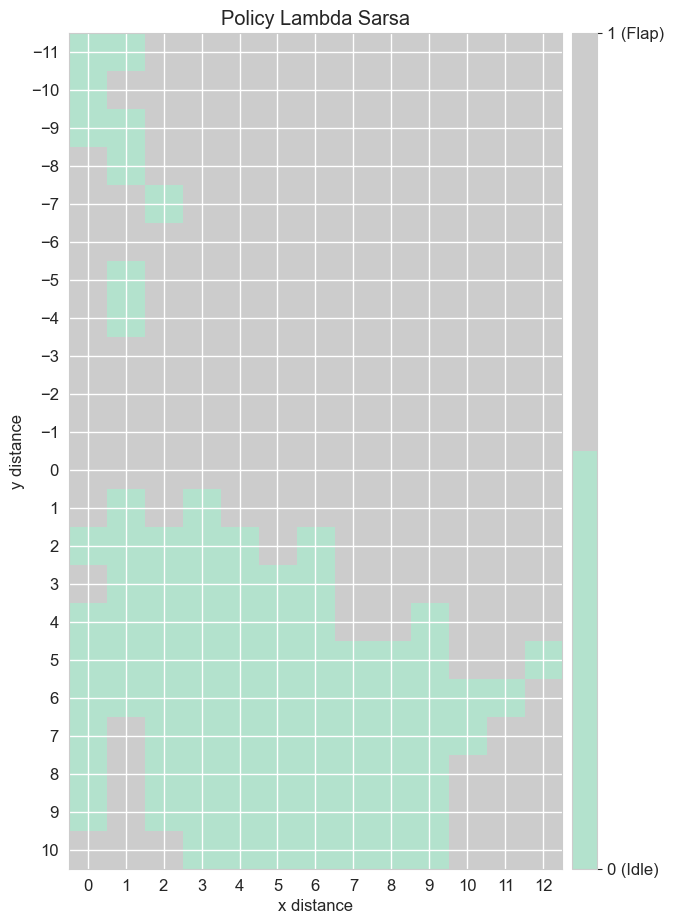

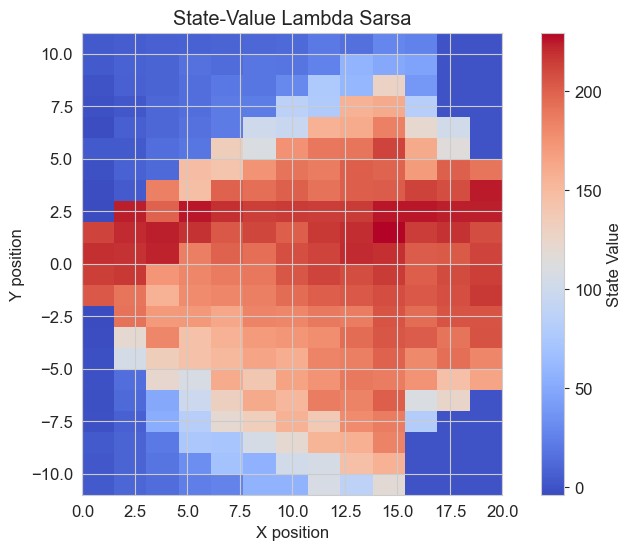

In [48]:
# In case loading the state value from saved:
V_1 = dict((k,np.max(v)) for k, v in avg_q_vals.items())
P_1 = dict((k,np.argmax(v)) for k, v in avg_q_vals.items())
plot_utils.plot_flappyBird_values(V_1, height, width, pipe_gap, {'title': f'State-Value {algorithm}'})
plot_utils.plot_policy(P_1, height, width, pipe_gap, {'title': f'Policy {algorithm}'})
plot_utils.plot_flappyBird_valuesCmap(V_1, height, width, pipe_gap, {'title': f'State-Value {algorithm}'})

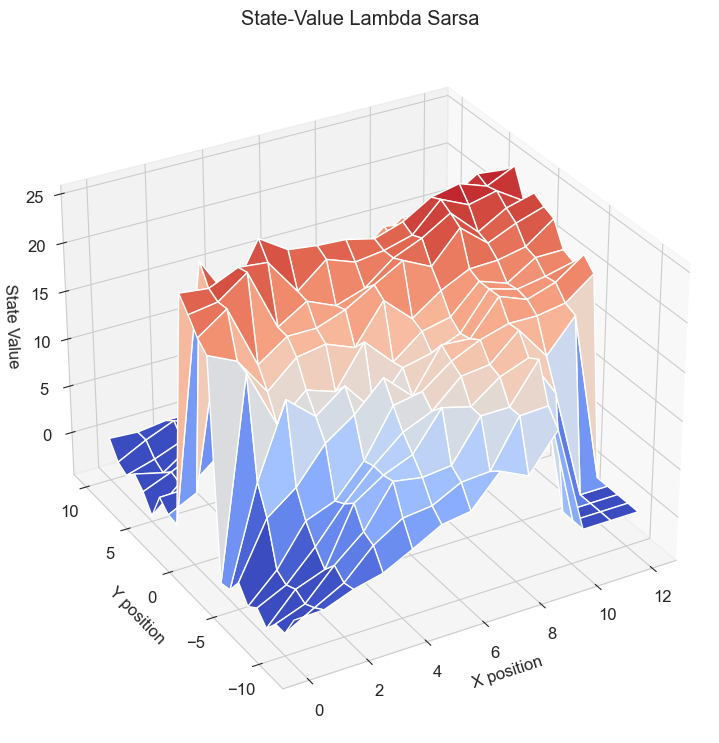

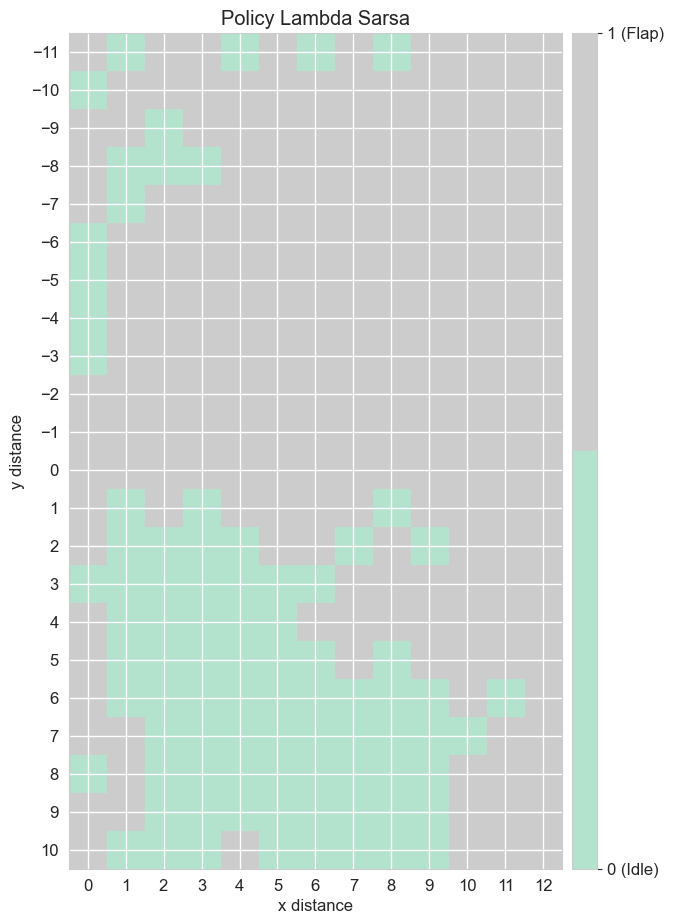

In [169]:
# In case want to plot directly from in RAM data
for algorithm in algos:
    V_1 = dict((k,np.max(v)) for k, v in averaged_V_values[algorithm].items())
    P_1 = dict((k,np.argmax(v)) for k, v in averaged_V_values[algorithm].items())
    plot_utils.plot_flappyBird_values(V_1, height, width, pipe_gap, {'title': f'State-Value {algorithm}'})
    plot_utils.plot_policy(P_1, height, width, pipe_gap, {'title': f'Policy {algorithm}'})
    plot_utils.plot_flappyBird_valuesCmap(P_1, height, width, pipe_gap, {'title': f'Policy {algorithm}'})

### Test Policy learned

In this section, I use a fixed policy agent based on the state_value function of the trained Lambda-Sarsa agent. And run this agent on 100 episodes, and 10 runs each.

In [ ]:
# Load last policy
algorithm = 'Lambda Sarsa'
q_vals_sarsa = np.load(f'results/{algorithm}_avg_V_values.npy',allow_pickle=True).item()
last_policy_sarsa = dict((k,np.argmax(v)) for k, v in q_vals_sarsa.items())

In [ ]:
agents_f = {
    "Fixed Agent": FixedAgent,
}
algos = ["Fixed Agent"]
all_reward_sums = {} # Contains sum of rewards during episode
all_scores_sums = {} # Contains sum of scores during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
V_values = {} # Contains state visit counts during the last 10 episodes

num_runs = 10 # The number of runs
num_episodes = 100 # The number of episodes in each run
max_episode_steps = 1000
env_info_changed = {'height': height, 'width': width, 'pipe_gap':pipe_gap}
for algorithm in algos:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    all_scores_sums[algorithm] = []
    V_values[algorithm] = []
    for run in tqdm(range(num_runs)):
        # Create environment
        env = gym.make('TextFlappyBird-v0', **env_info_changed)
        # Create Agent
        agent_info["seed"] = run
        current_agent = agents_f[algorithm]()
        current_agent.agent_init(agent_info)
        # Initialize Q value from learned
        for key, value in q_vals_sarsa.items():
            current_agent.q[key] = value
        reward_sums = []
        scores_sums = []
        state_visits = defaultdict(lambda: 0)
        for episode in tqdm(range(num_episodes), desc='Episode', leave=False):
            total_reward = 0
            state = env.reset()[0]
            action = current_agent.agent_start(state)
            # state_visits[state] += 1
            done = False
            t = 0
            while (not done):
                state, reward, done, _, info = env.step(action)
                next_action = current_agent.agent_step(reward, state)
                action = next_action
                if done == True:
                    current_agent.agent_end(reward)
                total_reward += reward
                t += 1
                if(t> max_episode_steps):
                    # print("Reached max episode limit")
                    break
            reward_sums.append(total_reward)
            scores_sums.append(info['score'])
            if episode % 100 == 0 and episode != 0:
                recent_mean_reward = np.mean(reward_sums)
                if recent_mean_reward > 100:
                    # print(f'Run {run}, Episode {episode}, Mean Reward: {recent_mean_reward}')
                    recent_reward_sums = []  # Clear recent rewards after printing
        all_scores_sums[algorithm].append(scores_sums)
        all_reward_sums[algorithm].append(reward_sums)
        env.close()
       

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


#### Rewards

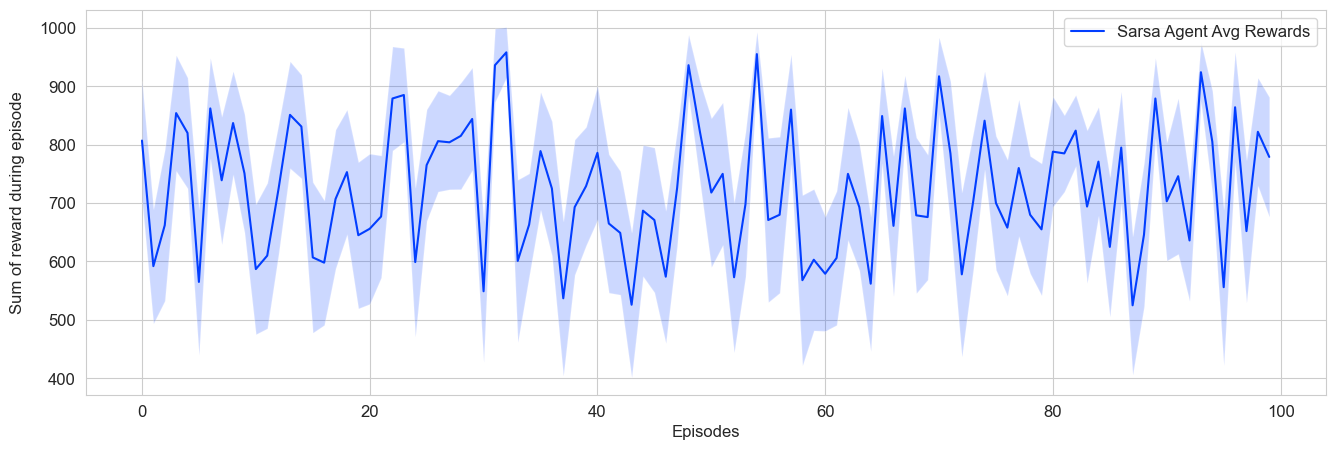

In [ ]:
plot_rewards(all_reward_sums['Fixed Agent'],100, {'label':'Sarsa Agent Avg Rewards'})

#### Scores

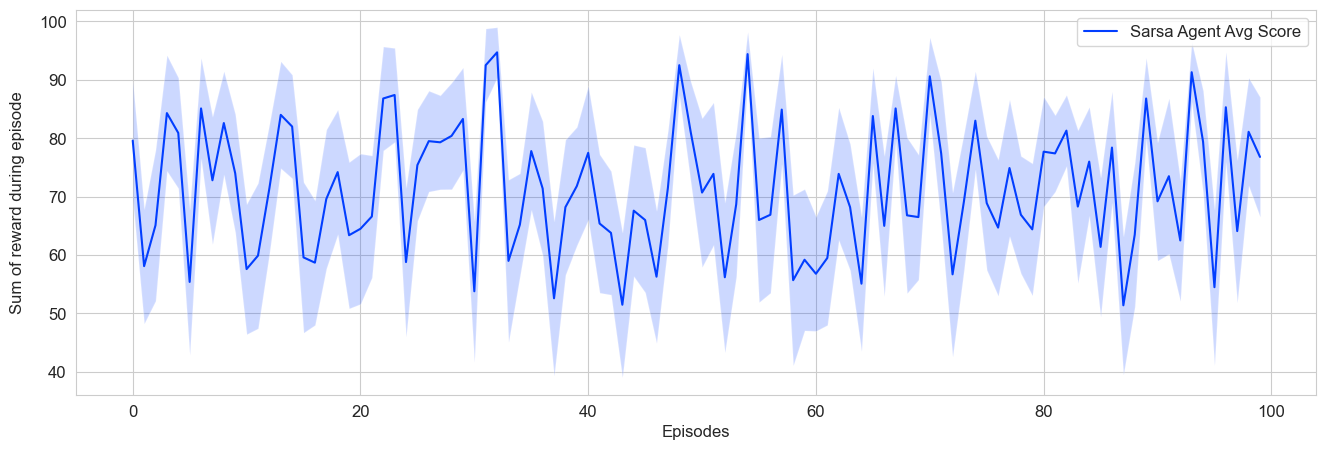

In [ ]:
plot_rewards(all_scores_sums['Fixed Agent'],100, {'label':'Sarsa Agent Avg Score'})

### Impact of parameters

In this section, I performed experiments to asses the impact of the agent parameters in the outcome during the training phase of the agent. For this, the step-size, epsilon, discount factor, and trace decay are changed. The average reward during  1000 episodes is registered and the variance in 10 runs is as well registered (Fill shape around the line).

In [34]:
def run_episode(current_agent, env, max_steps = 1000):
    total_reward = 0
    state = env.reset()[0]
    action = current_agent.agent_start(state)
    state_visits[state] += 1
    done = False
    while not done:
        state, reward, done, _, info = env.step(action)
        
        state_visits[state] += 1
        #Acquiring the on-policy next action
        next_action = current_agent.agent_step(reward, state)
        # print(next_action)
        action = next_action
        if done == True:
            current_agent.agent_end(reward)
            # reward = -1
        total_reward += reward
        if done:
            break
    return total_reward, state_visits

##### Impact of step-Size

In [ ]:
agents = {
    "Lambda Sarsa": LambdaSarsaAgent
}
algos = ['Lambda Sarsa']
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.2, "step_size": 0.5, "discount": 1, "seed": 0, 'trace_decay':0.8}

num_runs = 10
num_episodes = 1000

for algorithm in algos:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            env = gym.make('TextFlappyBird-v0', **env_info)
            agent_info["seed"] = run
            current_agent = agents[algorithm]()
            current_agent.agent_init(agent_info)
            return_sum = 0
            state_visits = defaultdict(lambda: 0)
            for episode in range(num_episodes):
                episode_reward, state_v = run_episode(current_agent, env)
                return_sum += episode_reward
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)

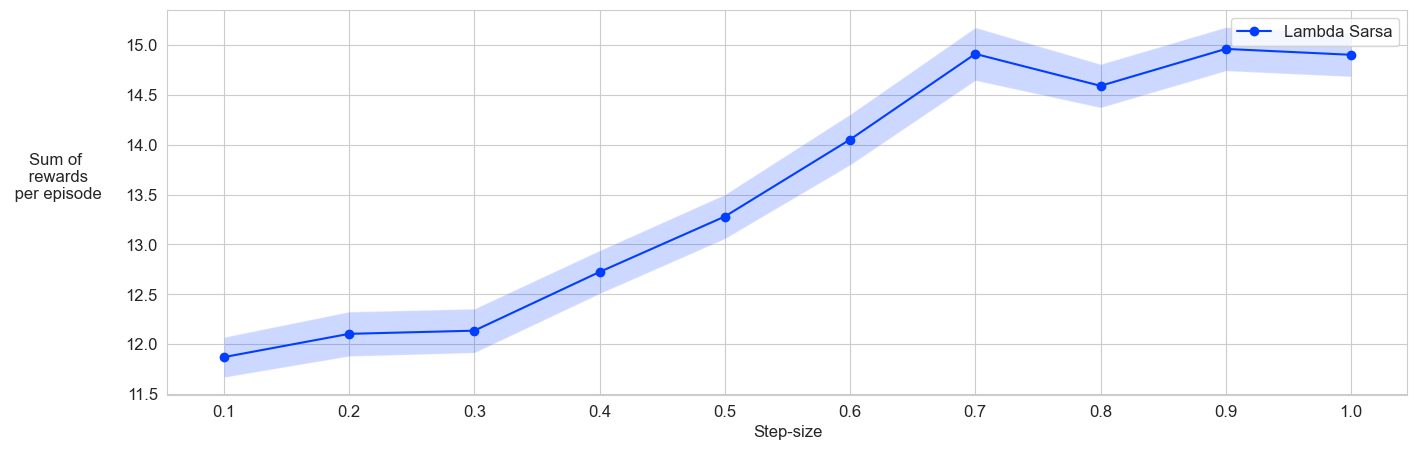

In [157]:
for algorithm in algos:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


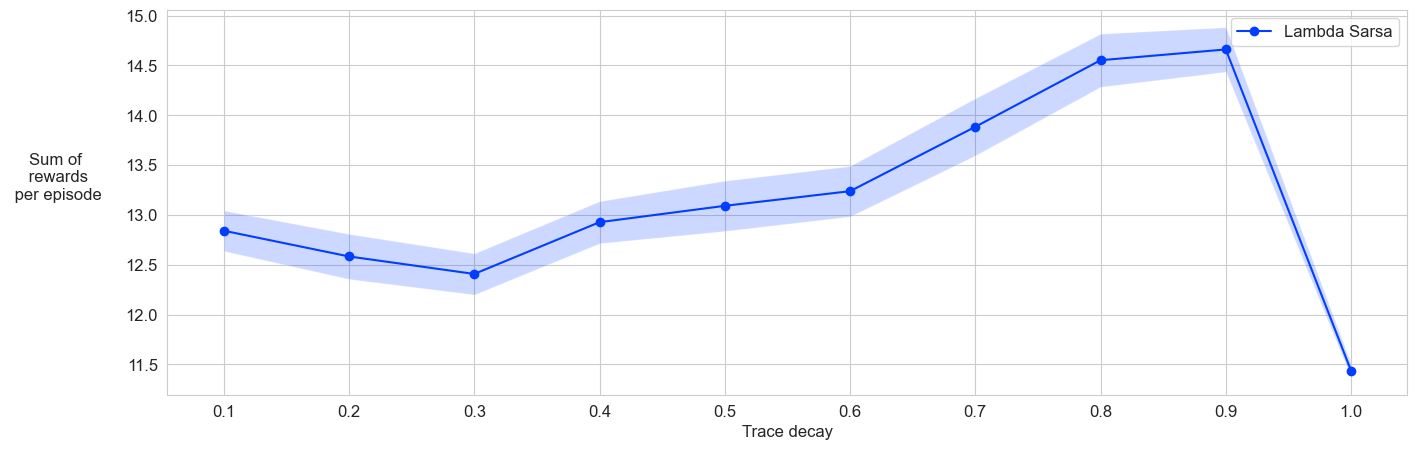

In [159]:
agents = {
    "Lambda Sarsa": LambdaSarsaAgent
}
algos = ['Lambda Sarsa']
all_reward_sums = {}
trace_decays = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.2, "step_size": 0.7, "discount": 1, "seed": 0, 'trace_decay':0.8}
num_runs = 100
num_episodes = 100

for algorithm in algos:
    for trace_decay in trace_decays:
        all_reward_sums[(algorithm, trace_decay)] = []
        agent_info["trace_decay"] = trace_decay
        for run in tqdm(range(num_runs)):
            env = gym.make('TextFlappyBird-v0', **env_info)
            agent_info["seed"] = run
            current_agent = agents[algorithm]()
            current_agent.agent_init(agent_info)
            return_sum = 0
            for episode in range(num_episodes):
                episode_reward, state_v = run_episode(current_agent, env)
                return_sum += episode_reward
            all_reward_sums[(algorithm, trace_decay)].append(return_sum/num_episodes)
        
for algorithm in algos:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, trace_decay)]) for trace_decay in trace_decays])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, trace_decay)]) for trace_decay in trace_decays])
    plt.plot(trace_decays, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(trace_decays, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Trace decay")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(trace_decays)
plt.show()

#### Impact of $\epsilon$

In [ ]:
all_reward_sums = {}
epsilons = np.linspace(0.05,0.7,6)
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.2, "step_size": 0.7, "discount": 1, "seed": 0, 'trace_decay':0.9}
num_runs = 60
num_episodes = 100

for algorithm in algos:
    for eps in epsilons:
        all_reward_sums[(algorithm, eps)] = []
        agent_info["epsilon"] = eps
        for run in tqdm(range(num_runs)):
            env = gym.make('TextFlappyBird-v0', **env_info)
            agent_info["seed"] = run
            current_agent = agents[algorithm]()
            current_agent.agent_init(agent_info)
            return_sum = 0
            for episode in range(num_episodes):
                episode_reward, state_v = run_episode(current_agent, env)
                return_sum += episode_reward
            all_reward_sums[(algorithm, eps)].append(return_sum/num_episodes)

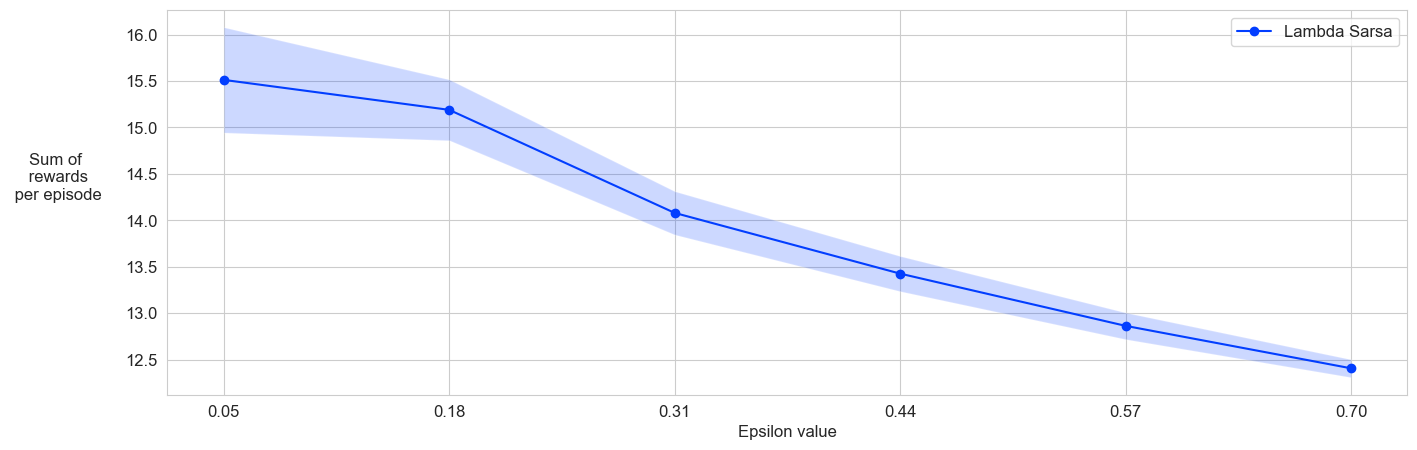

In [165]:
       
for algorithm in algos:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, trace_decay)]) for trace_decay in epsilons])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, trace_decay)]) for trace_decay in epsilons])
    plt.plot(epsilons, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(epsilons, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Epsilon value")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(epsilons)
plt.show()

#### Impact of discount

In [35]:
agents = {
    "Lambda Sarsa": LambdaSarsaAgent
}
algos = ['Lambda Sarsa']
reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 2, "num_states": states, "epsilon": 0.1, "step_size": 0.7, "discount": 1, "seed": 0, 'trace_decay':0.9}

num_runs = 10
num_episodes = 1000

for algorithm in algos:
    for step_size in step_sizes:
        reward_sums[(algorithm, step_size)] = []
        # Change discount value
        agent_info["discount"] = step_size
        for run in tqdm(range(num_runs)):
            env = gym.make('TextFlappyBird-v0', **env_info)
            agent_info["seed"] = run
            current_agent = agents[algorithm]()
            current_agent.agent_init(agent_info)
            return_sum = 0
            state_visits = defaultdict(lambda: 0)
            for episode in range(num_episodes):
                episode_reward, state_v = run_episode(current_agent, env)
                return_sum += episode_reward
            reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)

100%|██████████| 10/10 [03:35<00:00, 21.54s/it]


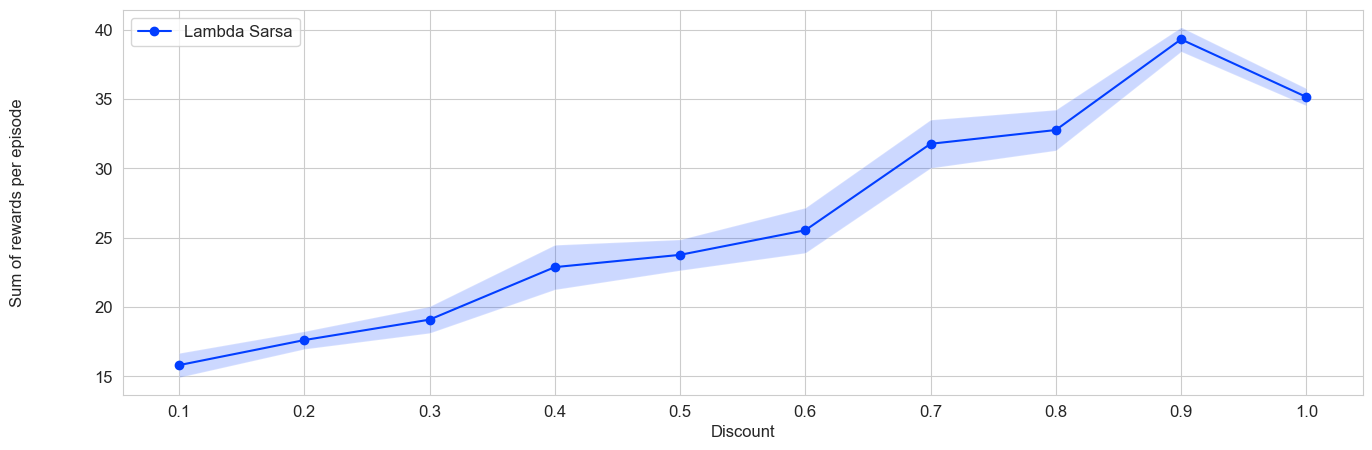

In [41]:
for algorithm in algos:
    algorithm_means = np.array([np.mean(reward_sums[(algorithm, step)]) for step in step_sizes])
    algorithm_stds = np.array([sem(reward_sums[(algorithm, step)]) for step in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Discount")
plt.ylabel("Sum of rewards per episode",rotation=90, labelpad=50)
plt.xticks(step_sizes)
plt.show()

## Comparing Monte-Carlo and Lambda Sarsa

Run Montecarlo for 1000 episodes and 10 runs

In [48]:
episode_durations =[]
num_runs = 10
num_episodes = 1000
all_rewards_mc = []
all_policies= []
all_q= []
for run in tqdm(range(num_runs), leave=False, desc='run'):
    p, q, r = mc_control(env, num_episodes, 0.5, plot_results=False)
    all_rewards_mc.append(r)
    all_policies.append(p)
    all_q.append(q)

run:   0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
all_reward_sums['Montecarlo'] = all_rewards_mc
algos = ["Lambda Sarsa", "Montecarlo"]

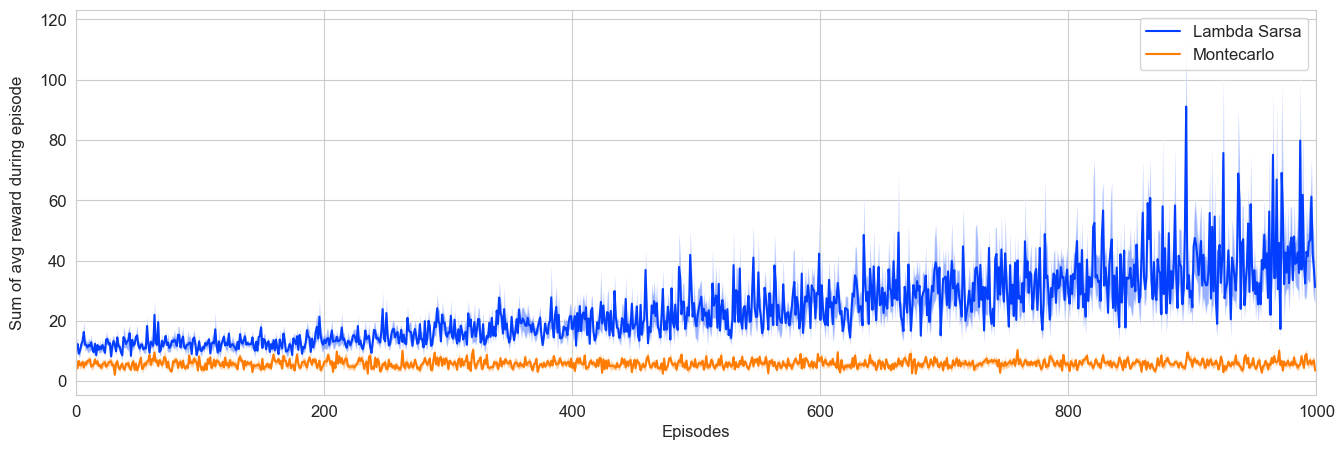

In [56]:
for algorithm in algos:
    # plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
    mean_rewards = np.mean(all_reward_sums[algorithm], axis=0)
    std_rewards = sem(all_reward_sums[algorithm], axis=0)
    sns.lineplot(x=np.arange(num_episodes), y=mean_rewards, label=algorithm)
    plt.fill_between(np.arange(num_episodes), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.4)
plt.xlabel("Episodes")
plt.ylabel("Sum of avg reward during episode",rotation=90, labelpad=10)
plt.xlim(0,num_episodes)
# plt.ylim(8000,10000)
plt.legend()
plt.show()

## Using policy-learned in changed environment

In [20]:
# Load last policy from Lambda-Sarsa
algorithm = 'Lambda Sarsa'
q_vals_sarsa = np.load(f'results/{algorithm}_avg_V_values.npy',allow_pickle=True).item()
last_policy_sarsa = dict((k,np.argmax(v)) for k, v in q_vals_sarsa.items())

In [40]:
# Do not modify this cell
agents_f = {
    "Fixed Agent": FixedAgent,
}
# algos = ["Lambda Sarsa"]
algos = ["Fixed Agent"]
num_runs = 10 # The number of runs
num_episodes = 100 # The number of episodes in each run
max_episode_steps = 1000
env_info_changed = {'height': 15, 'width': width, 'pipe_gap':pipe_gap}
def test_experiment(num_runs, num_episodes,agents_f, agent_info, env_info_changed):
    all_reward_sums = {} # Contains sum of rewards during episode
    all_scores_sums = {} # Contains sum of scores during episode
    all_state_visits = {} # Contains state visit counts during the last 10 episodes
    V_values = {} # Contains state visit counts during the last 10 episodes
    all_reward_sums = []
    all_state_visits = []
    all_scores_sums = []
    V_values = []
    for run in tqdm(range(num_runs)):
        # Create environment
        env = gym.make('TextFlappyBird-v0', **env_info_changed)
        # Create Agent
        agent_info["seed"] = run
        # Initialize Q value from last learned
        agent_info["qvalues"] = q_vals_sarsa
        current_agent = agents_f()
        current_agent.agent_init(agent_info)
        reward_sums = []
        scores_sums = []
        state_visits = defaultdict(lambda: 0)
        for episode in tqdm(range(num_episodes), desc='Episode', leave=False):
            total_reward = 0
            state = env.reset()[0]
            action = current_agent.agent_start(state)
            # state_visits[state] += 1
            done = False
            t = 0
            while (not done):
                state, reward, done, _, info = env.step(action)
                next_action = current_agent.agent_step(reward, state)
                action = next_action
                if done == True:
                    current_agent.agent_end(reward)
                total_reward += reward
                t += 1
                if(t> max_episode_steps):
                    # print("Reached max episode limit")
                    break
            reward_sums.append(total_reward)
            scores_sums.append(info['score'])
            if episode % 100 == 0 and episode != 0:
                recent_mean_reward = np.mean(reward_sums)
                if recent_mean_reward > 100:
                    # print(f'Run {run}, Episode {episode}, Mean Reward: {recent_mean_reward}')
                    recent_reward_sums = []  # Clear recent rewards after printing
        all_scores_sums.append(scores_sums)
        all_reward_sums.append(reward_sums)
        env.close()
    return all_reward_sums,all_scores_sums
       

In [59]:
algos = ["Fixed Agent"]
num_runs = 10 # The number of runs
num_episodes = 100 # The number of episodes in each run
max_episode_steps = 2000
agent_info["qvalues"] = q_vals_sarsa
heights = np.arange(8,40, 2)
all_rewards_height = []
all_scores_height = []
for h in heights:
    env_info_changed = {'height': h, 'width': width, 'pipe_gap':pipe_gap}
    r, s = test_experiment(num_runs,num_episodes, agents_f['Fixed Agent'],agent_info, env_info_changed)
    all_rewards_height.append(r)
    all_scores_height.append(s)


100%|██████████| 10/10 [00:00<00:00, 10.11it/s]


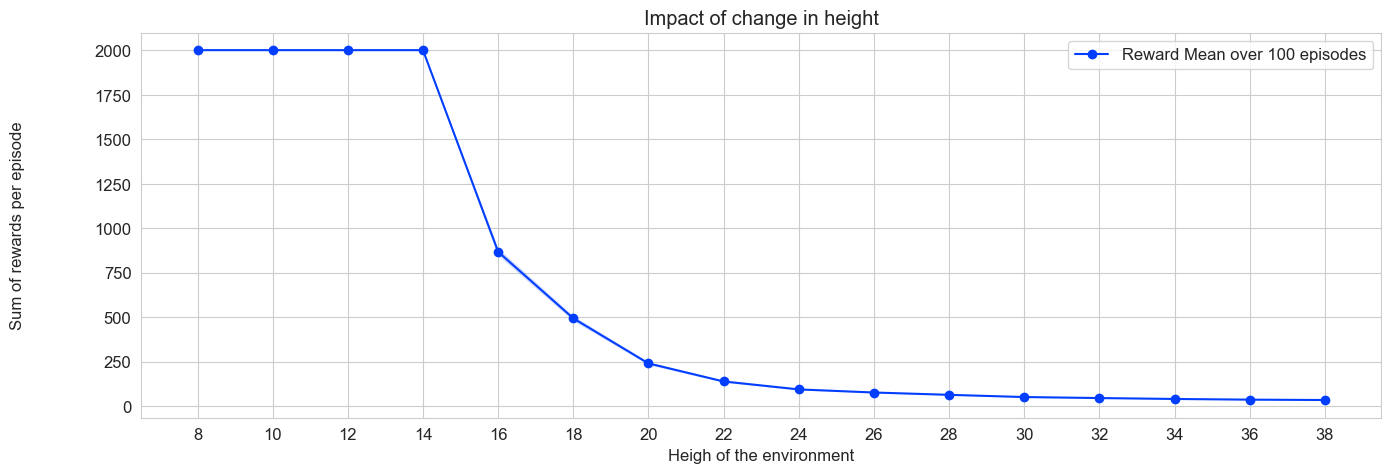

In [60]:
reward_sums = [np.sum(r, axis=1)/len(r[0]) for r in all_rewards_height]
reward_means = np.mean(reward_sums, axis=1)
reward_stds = np.array([sem(reward_sums[i]) for i in range(len(heights))])
plt.plot(heights, reward_means, marker='o', linestyle='solid', label=f'Reward Mean over {num_episodes} episodes')
plt.fill_between(heights, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Heigh of the environment")
plt.ylabel("Sum of rewards per episode",rotation=90, labelpad=50)
plt.title("Impact of change in height")
plt.xticks(heights)
plt.show()

In [50]:
widths = np.arange(5,45, 5)
all_rewards_w = []
all_scores_w = []
for w in widths:
    env_info_changed = {'height': height, 'width': w, 'pipe_gap':pipe_gap}
    r, s = test_experiment(num_runs,num_episodes, agents_f['Fixed Agent'],agent_info, env_info_changed)
    all_rewards_w.append(r)
    all_scores_w.append(s)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\JavierGonzalez\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\JavierGonzalez\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


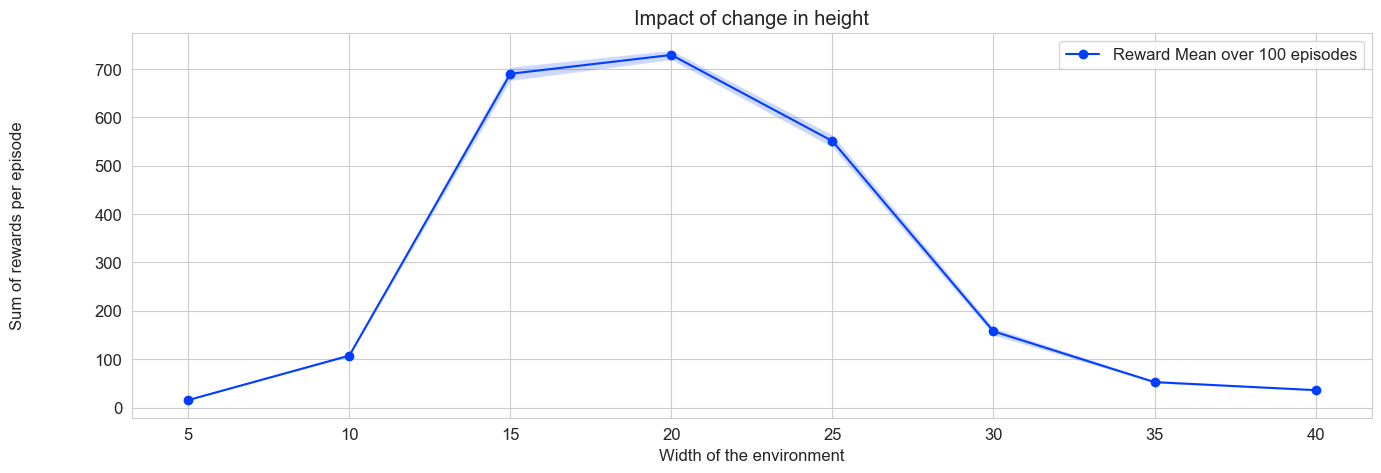

In [52]:
reward_sums = [np.sum(r, axis=1)/len(r[0]) for r in all_rewards_w]
reward_means = np.mean(reward_sums, axis=1)
reward_stds = np.array([sem(reward_sums[i]) for i in range(len(widths))])
plt.plot(widths, reward_means, marker='o', linestyle='solid', label=f'Reward Mean over {num_episodes} episodes')
plt.fill_between(widths, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Width of the environment")
plt.ylabel("Sum of rewards per episode",rotation=90, labelpad=50)
plt.title("Impact of change in height")
plt.xticks(widths)
plt.show()

In [53]:
pipe_gaps = np.arange(1,10, 2)
all_rewards_p = []
all_scores_p = []
for p in pipe_gaps:
    env_info_changed = {'height': height, 'width': width, 'pipe_gap':p}
    r, s = test_experiment(num_runs,num_episodes, agents_f['Fixed Agent'],agent_info, env_info_changed)
    all_rewards_p.append(r)
    all_scores_p.append(s)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\JavierGonzalez\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
c:\Users\JavierGonzalez\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


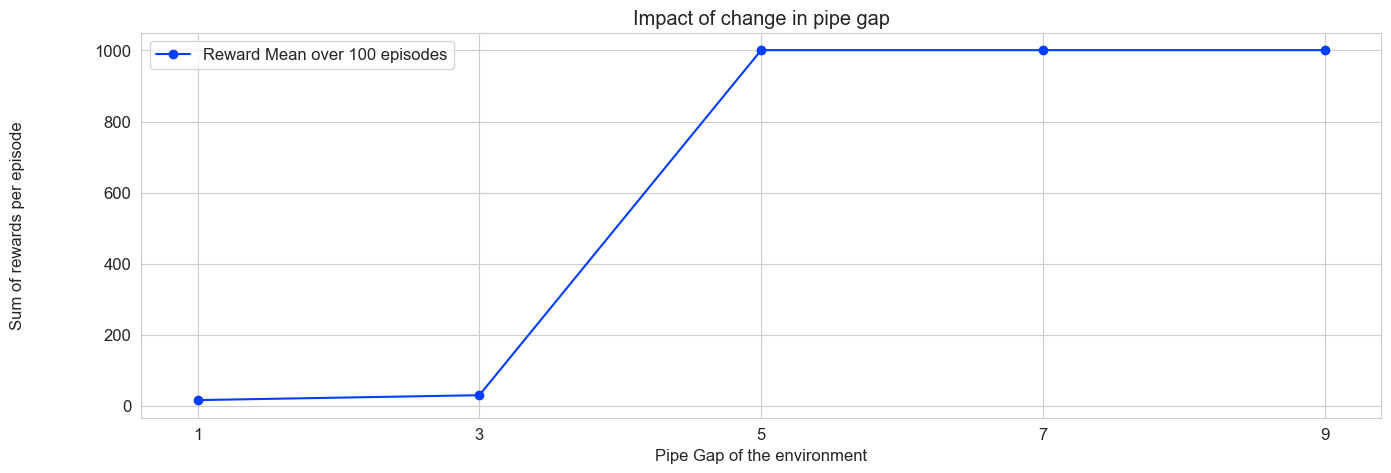

In [54]:
reward_sums = [np.sum(r, axis=1)/len(r[0]) for r in all_rewards_p]
reward_means = np.mean(reward_sums, axis=1)
reward_stds = np.array([sem(reward_sums[i]) for i in range(len(pipe_gaps))])
plt.plot(pipe_gaps, reward_means, marker='o', linestyle='solid', label=f'Reward Mean over {num_episodes} episodes')
plt.fill_between(pipe_gaps, reward_means + reward_stds, reward_means - reward_stds, alpha=0.2)

plt.legend()
plt.xlabel("Pipe Gap of the environment")
plt.ylabel("Sum of rewards per episode",rotation=90, labelpad=50)
plt.title("Impact of change in pipe gap")
plt.xticks(pipe_gaps)
plt.show()

# Environment Screen

In [179]:
print(env_screen.observation_space)
print(env_screen.action_space)

Box(0, 3, (20, 15), int32)
Discrete(2)


In [180]:
for i_episode in range(3):
    state = env_screen.reset()
    while True:
        action = env_screen.action_space.sample()
        state, reward, done, truncated, info = env_screen.step(action)
        print((state, reward, done, truncated, info))
        if done:
            print('End game! Reward: ', reward)
            break

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 2, 2

This environment returns an array of dimension width x height, where the value in the array items represent:
1 - For the player
2 - For the presence of a pipe
The index of the number represents the ubication in x, y in the game.